# p300 Speller Application
By: Thomas Blalock<br>
Date: December 6, 2023<br>
GitHub: https://github.com/ThomasBlalock/P300_BCI_Speller<br>
### Abstract
This paper details the development of a brain-computer interface (BCI) speller application using electroencephalography (EEG) to detect P300 event-related potentials. The system utilizes a 3D-printed EEG helmet with 8 electrodes positioned to optimize P300 detection. Custom stimulus-producing software was created, including a box GUI to elicit strong P300 responses for pretraining and a QWERTY keyboard GUI to enable communication. Over 3,000 EEG samples were collected, preprocessed with filtering and smoothing techniques, and used to train a 5-layer convolutional neural network (CNN) to classify P300 responses. However, the CNN only achieved 51.30% validation accuracy, slightly better than the 50% baseline. Next steps to improve accuracy include collecting more training data, enhancing data preprocessing, and exploring different model architectures like recurrent neural networks. Overall, this research lays the groundwork for a BCI speller but further optimization is required to achieve usable accuracy.
### Contents
- Introduction
- Hardware Setup
- Hardware-Software Integration
- Stimulus-Producing Software
- Data Collection
- Data Preprocessing
- Data Loading
- Model Development
- Model Training
- Results
- Next Steps
- References

### Introduction
A brain-computer interface (BCI) reads and interprets the electromagnetic fields created by neural activity. This project employs a specific type of non-invasive BCI called electroencephalography (EEG), which reads electrical signals using electrodes that sit on a person's scalp. this project seeks to create a system called a speller application to enable people to communicate without any motor movement. Different BCI spellers utilize different signals in the brain. These various strategies for speller applications are referred to as speller paradigms. We employ the p300 speller paradigm, which utilizes the p300 novelty response in the brain that can be triggered by flashing colors as well as a digital keyboard that flashes in different patterns to determine what a subject is looking at. On the back-end, a classification model parses the data to determine if the p300 response is present. Significant noise is introduced in EEG systems, originating from other processes in the brain, the environment, and other processes in the body, such as blinking. Every part of this system pipeline can be optimized. The quality of the stimulus-producing software determines the size of the p300 response. The quality of data cleaning and feature extraction could determine if the model converges. And lastly, the quality of the machine learning model determines if the system yields the correct response. A literature report linked [here](https://docs.google.com/document/d/1aNbAXmB_J7fFUMmZ_Ofe9Z-wUfX3AwkIEsbiiaiTxu8/edit?usp=sharing) further details the methods and paradigms mentioned in this report.

### Hardware Setup
In this project, we used a 3D-printed plastic frame with eight OpenBCI electrodes and an OpenBCI Cyton Board. The equipment was provided by Dr. Mello from the USAFA ACCR. The electrodes were placed in the p300 configuration found at this [link](https://www.researchgate.net/figure/Common-electrode-setup-for-P300-spellers-according-to-8-Eight-EEG-electrodes-are_fig1_221583051#:~:text=Eight%20EEG%20electrodes%20are%20placed,is%20attached%20to%20the%20rig). The wires were oriented orthogonal to each other to minimize cross-contamination.<br><br>
<img src="content/helmet_front.jpg" width="300" height="300">
<img src="content/helmet_back.jpg" width="300" height="300">
<img src="content/helmet_bottom.jpg" width="300" height="300">

### Hardware-Software Integration
The software generated to interact with the helmet assumes that the helmet transmits the signal to the computer through a USB port. Since only one process can access a USB port at a time, our scripts and the OpenBCI GUI cannot be running at the same time. A 'Board' object was created to handle all interactions with the EEG helmet. The code is modular enough so that it would be very easy to change the script to receive the signal over wifi rather than the USB port. Run the following code block to define this object.

In [1]:
# Define the Board class
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.board_shim import BrainFlowInputParams
import time


class Board:
    """
    This class is a wrapper for the BrainFlow Cyton board. It allows you to
    start and stop the stream, and get data from the board.
    """

    def __init__(self, port = 'COM4'):
        """Initializes the board and prepares the session.
        
        Args:
            port (str): The port the board is connected to.
        """
        self.port = port
        # Prep board / data stream
        BoardShim.enable_dev_board_logger()
        params = BrainFlowInputParams()
        params.serial_port = self.port
        self.board = BoardShim(BoardIds.CYTON_BOARD, params)
        self.board.prepare_session()
        

    def __del__(self):
        """Releases the session."""
        self.board.release_session()    
        time.sleep(1.5) # It crashes if you  restart the board too quickly

    def start_stream(self):
        """Starts the stream."""
        self.board.start_stream()

    def stop_stream(self):
        """Stops the stream."""
        self.board.stop_stream()

    def get_data(self):
        """Gets the data from the board.
        
        Returns:
            list: The data from the board.
        """
        return self.board.get_board_data()

### Stimulus-Producing Software
The end goal is to have a QWERTY keyboard that utilizes a binary search with the p300 responses to find the letter that a subject is looking at. It was determined that the machine learning model would converge more quickly if it was first trained on a more prominent p300 signal and then trained on the QWERTY keyboard. There are two GUI objects that flash different colors to stimulate the P300 response. The first version flashes different-sized boxes while the second version performs the binary search using a QWERTY keyboard with some non-letter values. 

##### Box GUI
The first GUI is just a flashing box. It is designed to elicit a strong p300. The data collected using this GUI will be used to pretrain the model. The model will theoretically converge faster on a dataset with a more pronounced loss landscape. The GUI enables the user to specify differently sized and shaped boxes. This variation allows the user to vary the size of the p300 response since the size of the flashing box will likely correlate to the size of the p300 response. Multiple colors flash during a single sample. The colors and time between flashes are randomized to maximize the p300 response. The user controls the GUI by pressing any button to start a session and pressing any button to end the session. The following code block defines the 'Box_GUI' class.<br><br>
<video width=" " height=" " 
       src="content/box_video.mp4"  
       controls>
</video>

In [2]:
# Define the Box GUI class
import pygame
import random
import pyautogui


class Box_GUI:
    """
    This class is a wrapper for the pygame GUI. It allows you to
    flash a box on the screen and wait for a button press.
    """

    # Constants
    BLACK = (0, 0, 0)
    WHITE = (255, 255, 255)
    RED = (255, 0 , 0)
    GREEN = (0, 255, 0)
    YELLOW = (255, 255, 0)
    PURPLE = (255, 0, 255)
    BLUE = (0, 0, 255)
    ORANGE = (255, 165, 0)
    PINK = (255, 192, 203)
    COLOR_LIST = [RED, GREEN, YELLOW, PURPLE, BLUE, ORANGE, PINK]

    def __init__(self, window_size = None):
        """Initializes the pygame GUI and determines the window size.
        
        args:
            window_size (tuple): The size of the window. If None, the size of the screen is used.
        """
        if window_size == None:
            width, height = pyautogui.size()
        else:
            width, height = window_size
        self.window_size = (width, height-(height/20))

        # Prep pygame window
        pygame.init()
        self.screen = pygame.display.set_mode(self.window_size)
        self.screen.fill(self.BLACK)

    def __del__(self):
        pygame.quit()
    
    def reset_screen(self, box_size):
        """Resets the screen to black and draws a box in the center.
        
        args:
            box_size (tuple): The size of the box.
        """
        box_size = self.box_size_parser(box_size)
        center = ((self.window_size[0] - box_size[0])/2, (self.window_size[1] - box_size[1])/2)
        pygame.draw.rect(self.screen, self.GREEN, (center[0], center[1], box_size[0], box_size[1]), 0)
        pygame.display.update()
        pygame.display.flip()

    def flash_box(self, box_size, color='random'):
        """Flashes a box on the screen.
        
        args:
            box_size (tuple or string or int):
                tuple: (x_width, y_width) of the box
                string: 'screen' or 'full' to fill the screen
                int: the height and width of the box
            color (str): The color of the box. If 'random', a random color is chosen.
        """
        if color == 'random':
            color = random.choice(self.COLOR_LIST)
        box_size = self.box_size_parser(box_size)
        center = ((self.window_size[0] - box_size[0])/2, (self.window_size[1] - box_size[1])/2)
        pygame.draw.rect(self.screen, color, (center[0], center[1], box_size[0], box_size[1]), 0)
        pygame.display.update()
        pygame.display.flip()

    def button_press(self):
        """Listener for a button press."""
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                return True
        return False
    
    def box_size_parser(self, box_size):
        """Parses the box size input and returns.
        
        args:
            box_size (tuple or string or int):
                tuple: (x_width, y_width) of the box
                string: 'screen' or 'full' to fill the screen
                int: the height and width of the box
        
        returns:
            tuple: (x_width, y_width) of the box
        """
        if  type(box_size) == str:
            if box_size == 'screen' or box_size == 'full':
                return self.window_size
        elif type(box_size) == int:
            return (box_size, box_size)
        elif type(box_size) == tuple and len(box_size) == 2:
            return box_size
        else:
            raise ValueError('Invalid box size input: ' + type(box_size) + '. Must be string, int, or 2-valued tuple.')

pygame 2.5.1 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


##### Keyboard GUI
The other GUI is a QWERTY keyboard that performs a binary search to locate the letter a subject is looking at. Multiple colors flash during a single sample. The colors and time between flashes are randomized to maximize the p300 response. The user controls the GUI by pressing any button to start a session and pressing any button to end the session. The following code block defines the 'Keyboard_GUI' class.<br><br>
<video width=" " height=" " 
       src="content/keyboard_video.mp4"  
       controls>
</video>

In [3]:
# Define the Keyboard GUI class


class Keyboard_GUI:
    """
    This class is a wrapper for the pygame GUI. It allows you to
    display a keyboard and flash keys on the screen.
    Controls:
        - Any Key: Start the session
        - Any Key: End the session
    """

    # Constants
    BLACK = (0, 0, 0)
    WHITE = (255, 255, 255)
    RED = (255, 0 , 0)
    GREEN = (0, 255, 0)
    YELLOW = (255, 255, 0)
    PURPLE = (255, 0, 255)
    BLUE = (0, 0, 255)
    ORANGE = (255, 165, 0)
    PINK = (255, 192, 203)
    COLOR_LIST = [RED, YELLOW, PURPLE, BLUE, ORANGE, PINK]
    KEY_COLOR_LIST = [GREEN, YELLOW, PINK, WHITE]

    def __init__(self, window_size=None):
        """Initializes the pygame GUI and determines the window size.
        
        args:
            window_size (tuple): The size of the window. If None, the size of the screen is used.
        """
        if window_size == None:
            width, height = pyautogui.size()
        else:
            width, height = window_size
        self.window_size = (width, height-(height/20))
        self.window_size = (width, height-(height/20))
        self.keyboard = [["1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "Backspace", "End"],
                    ["Q", "W", "E", "R", "T", "Y", "U", "I", "O", "P","(", ")"],
                    ["A", "S", "D", "F", "G", "H", "J", "K", "L", ";", "'"], 
                    ["Z", "X", "C", "V", "B", "N", "M", ",", ".", "/", "Enter"],
                    ["       "]]

        # Prep pygame window
        pygame.init()
        self.screen = pygame.display.set_mode(self.window_size)
        self.screen.fill(self.BLACK)
        self.font = pygame.font.SysFont("Arial", 20)

    def __del__(self):
        pygame.quit()
    
    def reset_screen(self, button_size = None, flash_keys = [], color='random', target_letter=None):
        """Resets the screen to black and draws the keyboard.

        args:
            button_size (tuple): The size of the buttons.
            flash_keys (list): The keys to flash.
            color (str): The color of the flash. If 'random', a random color is chosen.
            target_letter (str): The target letter to display on the bottom left corner.
        """

        # Parse inputs
        if color == 'random':
            flash_color = random.choice(self.COLOR_LIST)
            flash_color_key = random.choice(self.KEY_COLOR_LIST)
        else:
            flash_color = color
        col_margin = 5
        row_margin = 5
        if button_size == None:
            button_size = (self.window_size[0]/13, self.window_size[1]/5)

        # Draw a big black box over everything
        pygame.draw.rect(self.screen, self.BLACK, (0, 0, self.window_size[0], self.window_size[1]), 0)
        
        # Draw buttons
        for y, row in enumerate(self.keyboard):
            for x, key in enumerate(row):
                
                # Determine color
                if key in flash_keys:
                    color = flash_color
                    key_color = flash_color_key
                else:
                    color = self.GREEN
                    key_color = self.BLACK

                # Determine indent
                if y>=1 and y<=3: # Letters
                    indent = 20
                elif key=="       ": # Space bar
                    button_size = (button_size[0]*5, button_size[1])
                    indent = int(self.window_size[0]/2 - button_size[0]/2)
                else:
                    indent = 0

                # Draw button
                pygame.draw.rect(self.screen, color, (indent+x*(button_size[0] + col_margin)+col_margin, 
                                                           y*(button_size[1] + row_margin)+row_margin, button_size[0], button_size[1]))
                text_surface = self.font.render(key, True, key_color)
                self.screen.blit(text_surface, (indent+x*(button_size[0] + col_margin)+col_margin+button_size[0]/2 - text_surface.get_width()/2, 
                                                y*(button_size[1] + row_margin)+row_margin+button_size[1]/2 - text_surface.get_height()/2))
        
        # Draw target letter on bottom left corner
        if target_letter is not None:
            text_surface = self.font.render(target_letter, True, self.WHITE)
            self.screen.blit(text_surface, (5 + text_surface.get_width(), 
                                            self.window_size[1] - 5 - text_surface.get_height()))

        pygame.display.flip()

    def button_press(self):
        """Listener for a button press."""
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                return True
        return False
    
    def get_keyboard(self):
        return self.keyboard
    
    def flash_keys(self, keys, color='random', target_letter=None):
        """Flashes keys on the keyboard.

        args:
            keys (str or list of str): The keys to flash.
            color (str or tuple): The color of the flash. If 'random', a random color is chosen.
            target_letter (str): The target letter to display on the bottom left corner.
        """
        if type(keys) == str:
            new_keys = [keys]
        elif type(keys) == list:
            new_keys = []
            if type(keys[0]) == list:
                for l in keys:
                    new_keys.extend(l)
            else:
                new_keys = keys
        else:
            raise ValueError('Invalid key input: ' + type(keys) + '. Must be string or list of strings.')
        
        self.reset_screen(flash_keys=new_keys, color=color, target_letter=target_letter)

    def get_search_pattern(self, prev_flash=None, response=True):
        """Gets the search pattern and full pattern from the previous flash.

        args:
            prev_flash (list): The keys previously flashed.
            response (bool): Whether the flashing keys contained the target.

        returns:
            tuple: (search_pattern (list of str), full_pattern (list of str))
        """

        if prev_flash is None: # First flash
            pattern = self.nested_to_1d_list(self.keyboard[:int(len(self.keyboard)/2)])
            full = self.nested_to_1d_list(self.keyboard)
        else:
            prev_flash = self.nested_to_1d_list(prev_flash)
            if response: # Target was in the flashing keys
                pattern = prev_flash[:int(len(prev_flash)/4)]
                full = prev_flash[:int(len(prev_flash)/2)]
            else: # Target was not in the flashing keys
                pattern = prev_flash[int(len(prev_flash)/2):int(3*len(prev_flash)/4)]
                full = prev_flash[int(len(prev_flash)/2):]
        
        return pattern, full
    
    def nested_to_1d_list(self, l):
        """Recursively converts a nested list to a 1D list.

        args:
            l (list): The nested list.
        
        returns:
            list: The 1D list.
        """

        new_l = []
        if type(l)!=list:
            new_l.append(l)
        else:
            for item in l:
                new_l.extend(self.nested_to_1d_list(item))
        return new_l

### Data Collection
Data collection was handled using a separate object named 'DataAcquisitionHandler'. This object has methods to collect data using both the box GUI and the keyboard GUI. It contains a 'Board' object and stores all the data internally. The following code block defines the object.

In [4]:
# Define DataAcquisitionHandler class
import numpy as np
import random
import time


class DataAcquisitionHandler:
    """Handles data acquisition from the Cyton board using the Board class and GUIs."""

    def __init__(self, port = 'COM4', flash_time = (0.1, 0.3), wait_time = (1.5, 2.5), sample_time=1):
        """Initializes the DataAcquisitionHandler.

        Args:
            port (str): The USB port the board is connected to.
            flash_time (tuple): The range of time to flash the box for.
            wait_time (tuple): The range of time to wait between flashes.
            sample_time (float): The length of samples to collect.
        """

        self.flash_time = flash_time
        self.wait_time = wait_time
        self.sample_time = sample_time
        self.__board_port = port
        self.__data = {}

    def get_data(self):
        return self.__data

    def run_data_trial_box(self, box_size = 'screen', simulate=False, window_size = None, description=None):
        """Runs a data trial for the box GUI.

        Args:
            box_size (tuple or string or int):
                tuple: (x_width, y_width) of the box
                string: 'screen' or 'full' to fill the screen
                int: the height and width of the box
            simulate (bool): Whether to simulate the trial or not.
            window_size (tuple): The size of the window. If None, the size of the screen is used.
            description (str): A text description of the trial.

        Postconditions:
            self.__data: The data from the trial is added to the data dictionary.
        """

        # Initialize
        trials = []
        if window_size is not None:
            GUI = Box_GUI(window_size=window_size)
        else:
            GUI = Box_GUI()
        GUI.reset_screen(box_size)
        if not simulate:
            board = Board(self.__board_port)

        # Wait for any button press to start sequence
        while True:
            if GUI.button_press():
                break

        # Start data stream if not simulating
        if  not simulate:
            start_time = time.time()
            board.start_stream()

        # Data collection loop
        while True:
            GUI.reset_screen(box_size)

            # Make random wait time in wait_time range
            wait_time = random.uniform(self.wait_time[0], self.wait_time[1])
            i = 0

            # Check for button press to end trial
            end = False
            while i < wait_time:
                if GUI.button_press():
                    end = True
                    break
                time.sleep(0.1)
                i += 0.1
            if end:
                break

            if not simulate:
                trial_start_time = time.time()
            
            # Randomly choose to flash or not
            run_flash = random.choice([True, False])

            # Flash screen
            if run_flash:
                sample_time = 0
                while sample_time < self.sample_time:
                    GUI.flash_box(box_size)

                    # Select random flash time for inter-sample flashes
                    flash_time = random.uniform(self.flash_time[0], self.flash_time[1])
                    if sample_time + flash_time > self.sample_time:
                        flash_time = self.sample_time - sample_time
                    time.sleep(flash_time)
                    sample_time += flash_time
            else:
                time.sleep(self.sample_time)
            
            # print("Label : "+str(run_flash)) # Debugging print statement

            # Get metadata and add to trials list
            if not simulate:
                trial_end_time = time.time()

                trial_timestamps = (trial_start_time - start_time, trial_end_time - start_time)
                trial = {'timestamp': trial_timestamps, 'label': run_flash}

                trials.append(trial) # [{'timestamp': (start, end), 'flash_time': flash_time}, ...]
        
        # Gather data and stop stream if not simulating
        if not simulate:
            data = board.get_data()
            board.stop_stream()
            del board

        del GUI

        # Save data to dict
        if not simulate:
            end_time = time.time() - start_time
            metadata = {
                'start_time': start_time, # time in seconds
                'length': end_time, # time in seconds
                'trials': trials, # [(start, end), (start, end), ...]
                'flash_time_range': self.flash_time, # time in seconds
                'sample_time': self.sample_time, # time in seconds
                'box_size': box_size,
                'description': description # Text description passed in as an input
            }

            session_data = [{
                'metadata': metadata, # {'start_time': start_time, 'length': length 'flash_time': flash_time, 'timestamps': [(start, end), (start, end), ...]}}
                'data': data # [channel_1, channel_2, ..., channel_24]
            }]

            # Save data to dict
            self.add_data({'box_data': session_data})

    def run_data_trial_QWERTY(self, letter="Random", simulate=False, window_size=None, description=None):
        """Runs a data trial for the keyboard GUI.

        Args:
            letter (str): The target letter to display on the bottom left corner.
            simulate (bool): Whether to simulate the trial or not.
            window_size (tuple): The size of the window. If None, the size of the screen is used.
            description (str): A text description of the trial.

        Postconditions:
            self.__data: The data from the trial is added to the data dictionary.
        """

        if letter=="Random":
            random_letter = True
        else:
            random_letter = False

        # Initialize
        trials = []
        if window_size is not None:
            GUI = Keyboard_GUI(window_size=window_size)
        else:
            GUI = Keyboard_GUI(window_size = (1920, 1080))
        GUI.reset_screen()

        if not simulate:
            board = Board(self.__board_port)

        # Wait for any button press to start sequence
        while True:
            if GUI.button_press():
                break

        end = False

        if not simulate:
            start_time = time.time()
            board.start_stream()

        # Data collection loop
        while True:

            pattern = None
            label = True

            if end:
                break

            # Generate a random letter as the target
            if random_letter:
                choices = GUI.nested_to_1d_list(GUI.get_keyboard())
                random_idx = np.random.randint(0, len(choices))
                letter = choices[random_idx]
                
            GUI.reset_screen(target_letter=letter)

            # Binary search loops
            while True:
                GUI.reset_screen(target_letter=letter)

                # Make random wait time in wait_time range
                wait_time = random.uniform(self.wait_time[0], self.wait_time[1])

                # Check for button press to end trial
                i = 0
                end = False
                while i < wait_time:
                    if GUI.button_press():
                        end = True
                        break
                    time.sleep(0.1)
                    i += 0.1
                if end:
                    break

                # Get flash pattern
                if pattern is None:
                    pattern, full = GUI.get_search_pattern()
                elif (len(pattern)==1 or len(pattern)==0) and label:
                    break
                elif len(full)==2:
                    break
                else:
                    pattern, full = GUI.get_search_pattern(prev_flash=full, response=label)

                if not simulate:
                    trial_start_time = time.time()

                # Flash screen
                sample_time = 0
                while sample_time < self.sample_time:
                    GUI.flash_keys(keys=pattern, target_letter=letter)

                    # Select random flash time for inter-sample flashes
                    flash_time = random.uniform(self.flash_time[0], self.flash_time[1])
                    if sample_time + flash_time > self.sample_time:
                        flash_time = self.sample_time - sample_time
                    time.sleep(flash_time)
                    sample_time += flash_time

                # Get metadata and add to trials list
                if not simulate:
                    trial_end_time = time.time()
                    trial_timestamps = (trial_start_time - start_time, trial_end_time - start_time)
                    
                label = self._get_label_keyboard(letter, pattern)
                # print("Pattern : "+str(pattern)) # Debugging print statements
                # print("Label : "+str(label))
                # print("Letter : "+str(letter))

                # Create trial and add to trials list
                if not simulate:
                    trial = {
                        'timestamp': trial_timestamps,
                        'pattern': pattern,
                        'letter': letter,
                        'label': label
                    }
                    trials.append(trial)
        
        # Gather data and stop stream if not simulating
        if not simulate:
            data = board.get_data()
            board.stop_stream()
            del board

        del GUI

        # Save data to dict
        if not simulate:
            end_time = time.time() - start_time
            metadata = {
                'start_time': start_time, # time in seconds
                'length': end_time, # time in seconds
                'trials': trials, # [(start, end), (start, end), ...]
                'flash_time_range': self.flash_time, # time in seconds
                'sample_time': self.sample_time, # time in seconds
                'description': description # Text description passed in as an input
            }

            session_data = [{
                'metadata': metadata, # {'start_time': start_time, 'length': length 'flash_time': flash_time, 'trials': [{'timestamp': (start, end), 'pattern': pattern, 'letter': letter, 'label' label}...}}
                'data': data # [channel_1, channel_2, ..., channel_24]
            }]

            self.add_data({'keyboard_data': session_data})

    def _get_label_keyboard(self, letter, pattern):
        """Determines whether the target letter was in the flashing keys."""
        if letter in pattern:
            return True
        else:
            return False

    def add_data(self, data):
        """Adds data to the data dictionary.

        Args:
            data (dict): The data to add to the dictionary.
        """

        for key in data.keys():
            if key in self.__data.keys():
                self.__data[key].extend(data[key]) # append to existing key
            else:
                self.__data[key] = data[key] # create new key

The following code blocks run the scripts to collect data. Each session of data is attached to an unstructured description to allow the user to specify anything notable about the data collection session, such as environmental conditions, electrical impedance, and factors about the subject that would affect their neurochemistry like hours of sleep. The code below is in 'simulation' mode so that it can be run without the Cyton board. The GUIs are controlled by pressing any key to start and pressing any key to end a session.

In [5]:
# Imports and initialization
import pickle
import datetime
session_num = "1"
handler = DataAcquisitionHandler()

In [6]:
# Data collection session description
time_of_day = "Time: "+datetime.datetime.now().strftime("%H%M")+"/n"
sleep = "Sleep last night: 7 hours/n"
location = "Location: College dorm room/n"
score = "Conducive environment to collect data (1/10): 9/n"
conditions = "Conditions: Dark room.. ~11 in monitor displaying GUI. Fullscreen/n"
sound = "Sound: Mostly quiet/n"
verification = "Impedence verified visually on OpenBCI GUI/n"
impedence = "Impedence: ~5/n"
message = time_of_day + sleep + location + conditions + score + verification + sound + impedence

The box GUI features flashing boxes in the middle of the screen. The user specifies the size of the box as an argument in the 'run_data_trial_box()' method. Whether or not the GUI flashes is randomized, meaning that a user might have to wait through several negative sample collections before they see the screen flash. After collecting the data, the entire 'DataAcquisitionHandler' object is printed to file using the 'pickle' library. These files will be read and the data preprocessed later in the process.

In [8]:
# Run box data collection session
handler.run_data_trial_box(box_size=500, description=message, simulate=True)

# Save data
save_data = False
if save_data:
    filename = "C:/Users/c25th/code/P300_BCI_Speller/"
    filename += "data/handlers/"
    filename += "handler_"+datetime.datetime.now().strftime("%Y-%m-%d")+"_"+session_num+".pkl"
    with open(filename, 'wb') as f:
                pickle.dump(handler, f)

The keyboard GUI features a QWERTY keyboard which performs a binary search to locate the letter a subject is looking at. During data collection, the target letter is randomized and displayed by the GUI at the bottom left corner of the frame.

In [11]:
# Run keyboard data collection session
handler.run_data_trial_QWERTY(window_size=(1900, 1050),description=message, simulate=True)

# Save data
save_data = False
if save_data:
    filename = "C:/Users/c25th/code/P300_BCI_Speller/"
    filename += "data/handlers/"
    filename += "handler_"+datetime.datetime.now().strftime("%Y-%m-%d")+"_"+session_num+".pkl"
    with open(filename, 'wb') as f:
                pickle.dump(handler, f)

These GUIs produce the p300 stimulus when they flash. The randomization of the colors, the time intervals, and if the GUI flashes maximizes the p300 response since the subject cannot predict or expect certain stimuli with precision. The colors were selected to maximize the flashes' contrast with the background.


##### Data Collection for Curriculum Training
Designing two different methods to elicit the p300 response serves to enable the machine learning model to converge faster. Theoretically, the more pronounced the p300 response is in the data, the easier it will be for the model to identify it. Interpreted another way, the loss landscape for data with a more pronounced p300 response is less complex than it would be otherwise, meaning that the model would be less likely to get stuck in an unusable local minimum during training. An acceptable local minimum for this 'easy' dataset would likely be close enough to an acceptable local minimum for the 'harder' dataset. Thus, pretraining the model on the 'easy' dataset would enable the model to converge much faster on the 'hard' dataset. In this context, the 'easy' dataset includes samples gathered from the box GUI since having the entire screen flash takes up more visual space---and thus more cognitive space---than flashing a key on a QWERTY keyboard. The 'hard' dataset is composed of samples collected from the QWERTY keyboard. This process of pretraining on an 'easy' dataset before training the model directly on your real objective is referred to as 'curriculum training'.

### Data Preprocessing
Similarly to all electrical signal data, EEG data is extremely messy. In this project, the following cleaning methods were implemented to filter out extraneous data and help the model converge:
- Common Averaging
- Bandpass Filtering
- Signals Smoothing

Before implementing the above cleaning steps, we will load the 'DataAcquisitionHandler' objects and move the data to a 'DataObject' object to better organize the data and modularize the codebase.

In [12]:
# Define the 'load_data' function to load all files in a directory
def load_data(directory):
  """Loads all files in a directory into a list.

  Args:
    directory: The directory to load files from.

  Returns:
    A list of all the loaded files.
  """

  files = []
  for filename in os.listdir(directory):
    with open(os.path.join(directory, filename), "rb") as f:
      files.append(pickle.load(f))

  return files

In [13]:
# Define the 'DataObject' class and all its composition classes
class DataObject:
    """This class is a wrapper for the data collected from the Cyton board."""

    def __init__(self, data_dict, window_len = 250):
        """Initializes the DataObject with all the data.

        Args:
            data_dict (dict): The data dictionary from the handler object.
            window_len (int): The length of the window to use for each sample.
        """

        self.keyboard_sessions = []

        if 'keyboard_data' in data_dict.keys():
            keyboard_session_list = data_dict['keyboard_data']

            for session_dict in keyboard_session_list:
                self.keyboard_sessions.append(SessionData(session_dict=session_dict, type='keyboard', window_len = window_len))

        self.box_sessions = []

        if 'box_data' in data_dict.keys():
            box_session_list = data_dict['box_data']

            for session_dict in box_session_list:
                self.box_sessions.append(SessionData(session_dict=session_dict, type='box', window_len = window_len))


    def get_data(self, decorator=None, type='box'):
        """Gets the data from the DataObject.

        Args:
            decorator (object): The decorator object to use.
            type (str): The type of data to get. Either 'box' or 'keyboard'.
        """
        if decorator is None:
            keyboard_data = self.keyboard_sessions
            box_data = self.box_sessions
        else:
            keyboard_data, box_data = decorator.visit_data_object(object=self)
        return (keyboard_data, box_data)
    
    def accept(self, visitor):
        """Accepts a visitor object and calls the visit_data_object method."""
        visitor.visit_data_object(object=self)




class SessionData:
    """This class is a wrapper for the data collected from a single session."""
    
    def __init__(self, session_dict, type, window_len = 250):
        """Initializes the SessionData with all the data.

        Args:
            session_dict (dict): The session dictionary from the handler object.
            type (str): The type of session. Either 'box' or 'keyboard'.
            window_len (int): The length of the window to use for each sample.
        """
        metadata = session_dict['metadata']
        self.data = session_dict['data']
        self.start_time = metadata['start_time']
        self.length = metadata['length']
        self.flash_time_range = metadata['flash_time_range']
        self.sample_time = metadata['sample_time']
        self.description = metadata['description']
        self.type = type

        # Create trials list
        self.trials = []
        for trial in metadata['trials']:
            if self.type == 'keyboard':
                self.trials.append(KeyboardTrialData(trial_dict=trial, parent_session=self, window_len = window_len))
            elif self.type == 'box':
                self.trials.append(BoxTrialData(trial_dict=trial, parent_session=self, window_len = window_len))
            else:
                raise ValueError('Session type must be either keyboard or box')

    def get_data(self, decorator=None):
        """Gets the data from the SessionData.

        Args:
            decorator (object): The decorator object to use.
        """
        if decorator is None:
            trials = self.trials
        else:
            trials = decorator.visit_session_data(session=self)
        return trials
    
    def accept(self, visitor):
        """Accepts a visitor object and calls the visit_session_data method."""
        visitor.visit_session_data(session=self)



class TrialData:
    """This class is a wrapper for the data collected from a single trial."""

    def __init__(self, trial_dict, parent_session, window_len = 250):
        """Initializes the TrialData with all the data.

        Args:
            trial_dict (dict): The trial dictionary from the handler object.
            parent_session (object): The parent session object.
            window_len (int): The length of the window to use for each sample.
        """
        timestamp = trial_dict['timestamp']
        data_len = len(parent_session.data[0])
        self.start_idx = (int) ( (timestamp[0] / parent_session.length) * data_len )
        self.end_idx = self.start_idx + window_len
        self.label = trial_dict['label']
        self.parent_session = parent_session

    def get_data(self, decorator=None):
        """Gets the data from the TrialData.

        Args:
            decorator (object): The decorator object to use.
        """
        if decorator is None:
            data = self.parent_session.data[:, self.start_idx:self.end_idx]
        else:
            data = decorator.visit_trial_data(trial=self)
        return data
    
    def accept(self, visitor):
        """Accepts a visitor object and calls the visit_trial_data method."""
        visitor.visit_trial_data(trial=self)
    


class BoxTrialData(TrialData):
    """A subclass of TrialData for box trials."""

    def __init__(self, trial_dict, parent_session, window_len = 250):
        super().__init__(trial_dict, parent_session, window_len = window_len)



class KeyboardTrialData(TrialData):
    """A subclass of TrialData for keyboard trials."""

    def __init__(self, trial_dict, parent_session, window_len = 250):
        super().__init__(trial_dict, parent_session, window_len = window_len)
        self.pattern = trial_dict['pattern']
        self.letter = trial_dict['letter']

In [15]:
# Load all 'DataAcquisitionHandler' objects from a directory
import os
dir = "data/handlers"
handler_list = []
handler_list.extend(load_data(dir))

In order to proceed, we need the data to all be in on 'DataObject'. The following code block defines a visitor that combines the data from one 'DataObject' into a different 'DataObject'. The code block after it combines all the data into a single 'DataObject'.

In [16]:
# Define a 'DataVisitor' template class


class DataVisitor(object):

    def visit_data_object(self, object):
        raise NotImplementedError
    
    def visit_session_data(self, session):
        raise NotImplementedError

    def visit_trial_data(self, trial):
        raise NotImplementedError

In [17]:
# Define the 'AddDataVisitor' class


class AddDataVisitor(DataVisitor):
    """Adds data to the DataObject"""

    def __init__(self, dataObj):
        """Initializes the AddDataVisitor.
        
        Args:
            dataObj (object): The DataObject to add data to.
        """
        self.data = dataObj

    def visit_data_object(self, object):
        """Adds data to the DataObject.

        Args:
            object (object): The DataObject to add data to.
        """
        object.keyboard_sessions.extend(self.data.keyboard_sessions)
        object.box_sessions.extend(self.data.box_sessions)
    
    def visit_session_data(self, session):
        pass
    
    def visit_trial_data(self, trial):
        pass

In [33]:
# Combine all Handler objects into one single DataObject
data = DataObject(handler_list.pop(0).get_data())
for handler in handler_list:
    new_data_obj = DataObject(handler.get_data())
    data.accept(AddDataVisitor(new_data_obj))

##### Common Averaging
Variations in the placement of the helmet, electrical impedance, and numerous other factors can influence the average numeric value of a signal. Furthermore, the size of the p300 response can vary. These differences in magnitude among samples often hurt machine learning models' performances. This project normalizes the data using common averaging. Thus, data is generally normalized prior to training a model. The following code blocks defines a visitor object to normalize all the data in a 'DataObject' using common averaging.

In [19]:
# Define the 'CommonAveragingVisitor' class


class CommonAveragingVisitor(DataVisitor):
    
    def __init__(self):
        pass

    def visit_data_object(self, object):
        for session in object.keyboard_sessions:
            self.visit_session_data(session=session)

        for session in object.box_sessions:
            self.visit_session_data(session=session)

    def visit_session_data(self, session):
        data = []
        for i, channel in enumerate(session.data):
            if len(channel) == 0:
                continue

            # Only the channels with EM data will be filtered
            if i>1 and i<9:
                data.append(self.common_average(channel))
            else:
                data.append(channel)
        session.data = np.array(data)

    def common_average(self, channel):
        avg_signal = np.mean(channel, axis=0)
        avg_final = channel - avg_signal
        norm_data = (avg_final - np.min(avg_final)) / (np.max(avg_final) - np.min(avg_final))
        final_data = np.sqrt(norm_data)
        return final_data

##### Bandpass Filtering
The p300 stimulus response only occurs between 0.1 Hz and 30 Hz. Thus, every signal outside of that frequency range is noise and should be removed using a bandpass filter. The following code blocks define a filtering visitor template and a bandpass filter visitor.

In [20]:
# Define the 'FilterVisitor' class


class FilterVisitor(DataVisitor):
    """Temmplate class for filtering data."""

    SAMPLE_RATE = 250
    ORDER = 3

    def __init__():
        raise NotImplementedError

    def visit_data_object(self, object):
        """Filters all the data in the DataObject. Offloads logic to visit_session_data().

        Args:
            object (object): The DataObject to filter.
        """
        for session in object.keyboard_sessions:
            self.visit_session_data(session=session)

        for session in object.box_sessions:
            self.visit_session_data(session=session)
    
    def visit_session_data(self, session):
        """Filters all the data in the SessionData. Offloads logic to filter().

        Args:
            session (object): The SessionData to filter.
        """
        data = []
        for i, channel in enumerate(session.data):
            # Only the channels with EM data will be filtered
            if i>1 and i<9:
                data.append(self.filter(channel))
            else:
                data.append(channel)

        session.data = np.array(data)

    def visit_trial_data(self, trial):
        pass

    def filter(self, data):
        raise NotImplementedError
    


In [21]:
# Define the 'BandpassFilterVisitor' class
import scipy.signal as signal


class BandpassFilterVisitor(FilterVisitor):
    """Filters data using a bandpass filter."""

    def __init__(self, low, high):
        """Initializes the BandpassFilterVisitor.

        Args:
            low (int): The low cutoff frequency.
            high (int): The high cutoff frequency.
        """
        self.low = low
        self.high = high

    def filter(self, data):
        """Bandpass filter using scipy.signal.butter
        
        Args:
            data (list): The data to filter.
        """
        b, a = signal.butter(3, [self.low, self.high], btype='bandpass', fs=self.SAMPLE_RATE)
        return signal.lfilter(b, a, data)

##### Signals Smoothing
Signal data is plagued with random surges and irregular spikes that can drown out the desired signal. Smoothing the signal suppresses this randomness leaving only the longer trends. The p300 should yield a longer trend than background neural processes. This project smooths the data to suppress that background noise so it does not overwhelm the machine learning model. The following code block defines the visitor to smooth the data.

In [22]:
# Define the 'SmoothDataVisitor' class


class SmoothDataVisitor(FilterVisitor):
    """Smooths data using a moving average."""

    SAMPLE_RATE = 250

    def __init__(self, n=15, low=0.1, high=30):
        """Initializes the SmoothDataVisitor.

        Args:
            n (int): The number of samples to use for the moving average.
            low (int): The low cutoff frequency.
            high (int): The high cutoff frequency.
        """
        self.n = n
        self.b = [1.0/n] * n
        _, self.a = signal.butter(3, [low, high], btype='bandpass', fs=self.SAMPLE_RATE)

    def filter(self, channel):
        """Smooths the data using a moving average and a bandpass filter.

        Args:
            channel (list): The data to smooth.
        """
        return signal.lfilter(self.b, self.a, channel)

Now, we have a single data object with all our data and the visitor objects to clean the data. The following code block applies all the aforementioned cleaning steps to the data.

In [34]:
# Filter the data
data.accept(BandpassFilterVisitor(low=0.1, high=30))
data.accept(CommonAveragingVisitor())
data.accept(SmoothDataVisitor(low=0.1, high=30, n=15))

C:\Users\c25th\AppData\Local\Temp\ipykernel_11528\3941977868.py:32: RuntimeWarning: invalid value encountered in divide
  norm_data = (avg_final - np.min(avg_final)) / (np.max(avg_final) - np.min(avg_final))


### Data Loading
Now that the data is fully preprocessed, we will format it into a pytorch dataloader to train a neural network. The 'get_data()' method in the 'DataObject' accepts decorator objects as an argument. The following code blocks define a template decorator object, a decorator object to format the data into windows of fixed size, and a decorator to transform the data from numpy arrays into pytorch tensor windows of fixed size.

In [24]:
# Define the 'DataDecorator' template class


class DataDecorator(object):

    def visit_data_object(object):
        raise NotImplementedError
    
    def visit_session_data(session):
        raise NotImplementedError
    
    def visit_trial_data(trial, raw_data):
        raise NotImplementedError

In [25]:
# Define the 'MakeWindowsDataDecorator' class


class MakeWindowsDataDecorator(DataDecorator):
    """
    Returns a list of tuples ( data_window, label )
    """

    def __init__(self):
        pass


    def visit_data_object(self, object):
        """
        Returns a tuple of lists of tuples ( [( data_windows, label ) ...], [( data_windows, label ) ...] )
        This first is the keyboard data, the second is the box data
        """
        keyboard_sessions = object.keyboard_sessions
        box_sessions = object.box_sessions

        keyboard_data = []
        for session in keyboard_sessions:
            keyboard_data.extend(self.visit_session_data(session=session))

        box_data = []
        for session in box_sessions:
            box_data.extend(self.visit_session_data(session=session))

        return ( keyboard_data, box_data)
    

    def visit_session_data(self, session):
        """
        Returns a list of tuples ( data_windows, label )
        """
        data = []
        for trial in session.trials:
            data.append(self.visit_trial_data(trial=trial))
        return data
    

    def visit_trial_data(self, trial):
        """
        Returns a tuple ( data_windows, label )
        """

        window = self.transform_window(trial.parent_session.data[:, trial.start_idx:trial.end_idx])
        label = self.transform_label(trial.label)

        return ( window, label )
    
    def transform_window(window):
        return window
    
    def transform_label(label):
        return label

In [26]:
# Define the 'MakeTensorWindowsDataDecorator' class


class MakeTensorWindowsDataDecorator(MakeWindowsDataDecorator):
    """
    Returns a list of tuples ( data_window, label ) for each window in the format of a pytorch tensor
    """

    def transform_label(self, label):
        if not label:
            label = 0
        elif label:
            label = 1
        else:
            raise ValueError('MakeTensorWindowsDataVisitor object/ transform_label method: Label must be a boolean')
        
        return torch.tensor(label)
    
    def transform_window(self, window):
        return torch.from_numpy(window).float()

The following code block retrieves the data from the DataObject and converts it into a list of tuples ( data_window, label ) for each window in the format of a pytorch tensor. It also prints the sizes of each nested list/tensor and an example sample to verify the process worked as expected.

In [37]:
# Format data
import torch
keyboard_data, box_data = data.get_data(decorator=MakeTensorWindowsDataDecorator())

# Verify everything worked as expected
sample = box_data[0]
print("Number of samples:", len(box_data) + len(keyboard_data))
print("Sample Size - (channels, label): ({}, {})".format(len(box_data[0][0]), box_data[0][1].size()))
print("Channels size:", box_data[0][0].size())
print("Sample example:", sample)

Number of samples: 2551
Sample Length - (channels, label): (24, torch.Size([]))
Channels size: torch.Size([24, 250])
Sample example: (tensor([[ 1.7100e+02,  1.7200e+02,  1.7300e+02,  ...,  1.6200e+02,
          1.6300e+02,  1.6400e+02],
        [-8.2220e+03, -9.6580e+03, -9.1427e+03,  ..., -9.3020e+03,
         -9.5034e+03, -7.9860e+03],
        [ 1.9058e+07,  1.9184e+07,  1.9310e+07,  ...,  6.3440e+07,
          6.3667e+07,  6.3894e+07],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.7008e+09,  1.7008e+09,  1.7008e+09,  ...,  1.7008e+09,
          1.7008e+09,  1.7008e+09],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]]), tensor(1))


Pytorch dataloaders iterate through pytorch datasets to create batches of data. This project defines a custom 'EEGDataset' class in the following code block. Next, the data is loaded into an 'EEGDataset' object.

In [38]:
# Define the 'EEGDataset' class
from torch.utils.data import WeightedRandomSampler, Dataset

class EEGDataset(Dataset):
    """EEG dataset."""

    def __init__(self, data):
        """ Initializes the EEGDataset.

        Args:
            data (list of tuples (channels, label)): The data to use for the dataset.
        """
        self.data, self.labels = self.parse_data(data)
        self.window_size = self.data.shape[2]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def parse_data(self, data):
        """ Parses the data into a 3D tensor (X) and a 1D tensor (Y).

        Args:
            data (list of tuples (channels, label)): The data to parse.
                channels is a 2D tensor (channel number, readings)
                label is a 1D tensor (1)

        return:
            tuple: (X, Y)
                X: 3D tensor (samples, channels, readings)
                Y: 1D label tensor (samples)
        """

        data_list = []
        label_list = []

        channels_idx = (1, 9)

        for sample in data:
            data_list.append(sample[0][channels_idx[0]:channels_idx[1]])
            label_list.append(sample[1])

        return torch.stack(data_list), torch.stack(label_list)
    
    def downsample(self):
        """ Downsamples the dataset by removing samples from the majority class. """

        label_counts = torch.bincount(self.labels)
        min_count = torch.min(label_counts).item()

        downsampled_data = []
        downsampled_labels = []
        samples_per_class = dict()

        # Iterate over data and add samples to the new downsampled dataset
        for i in range(len(self.data)):
            label = self.labels[i].item()
            # If the class is not in the dictionary, or the count for this class is less than the minimum count
            if samples_per_class.get(label, 0) < min_count:
                # Add the sample to the downsampled set
                downsampled_data.append(self.data[i])
                downsampled_labels.append(self.labels[i])
                # Increment the count for this class in the dictionary
                samples_per_class[label] = samples_per_class.get(label, 0) + 1

        # Replace the dataset with the downsampled set, stacked into tensors
        self.data = torch.stack(downsampled_data)
        self.labels = torch.stack(downsampled_labels)

In [39]:
# Create dataset

# Set seed
torch.manual_seed(0)

# Make dataset
dataset = EEGDataset(box_data)

Although this project's method of collecting data makes it likely that the data will have almost as many samples of each class, it does not guarantee it. If a machine learning model is trained on a dataset with too many of one class, it will learn to always predict that class. To avoid this, we balance the dataset. There are two main methods of balancing datasets. The first is to augment the under-represented class by duplicating samples or adding transformed samples. The second method is to 'downsample', which means to remove samples of the over-represented class until the dataset contains equal amounts of classes. In this project, we undersample the dataset since it is more costly to transform the dataset with augmentations than it is to just collect more data. Thus, we will have an abundance of data and can afford to downsample.

In [40]:
# Even out class distribution by downsampling
dataset.downsample()

The following code block splits the dataset into a training, validation, and testing dataset. The datasets are used to create 'DataLoader' objects.

In [41]:
# Create training, validation, and testing dataloaders
from torch.utils.data import DataLoader

# Split into train and test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Print sizes
print("Train loader size:", len(train_loader))
print("Val loader size:", len(val_loader))
print("Test loader size:", len(test_loader))

Train loader size: 59
Val loader size: 8
Test loader size: 8


Although the overall dataset is balanced, each individual dataloader is not balanced. The following code block plots the distribution of labels so we can visually verify the distribution of the training dataloader is not problematic.

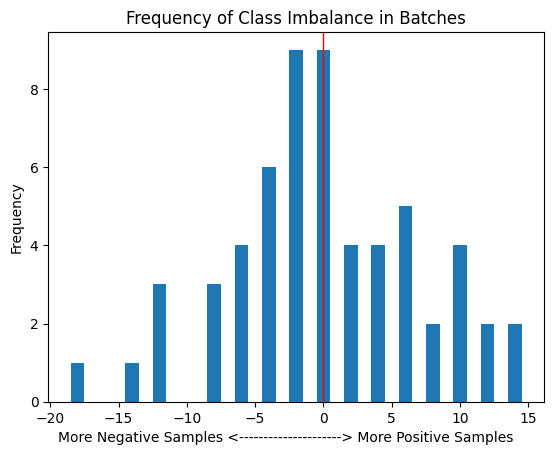

In [42]:
# Display the class distribution for the training dataloader
from matplotlib import pyplot as plt

# Difference between positive and negative samples for each batch
differences = []

# Analyze class distribution for each batch
for _, labels in train_loader:
    positive_count = (labels == 1).sum().item()
    negative_count = (labels == 0).sum().item()
    
    # Compute the difference and append to the list
    differences.append(positive_count - negative_count)

# Plotting the histogram
fig, ax = plt.subplots()
ax.hist(differences, bins=range(min(differences), max(differences) + 2), align='left')
ax.set_xlabel('More Negative Samples <---------------------> More Positive Samples     ')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Class Imbalance in Batches')
ax.axvline(0, color='red', linewidth=1)  # Draw a vertical line at zero for reference

plt.show()

Now, the data is completely ready for model training. The following code block prints the data to file using pytorch's built-in functionality.

In [44]:
# Print the dataloaders to file
filepath = "data/dataloaders/"
date = datetime.datetime.now().strftime("%Y-%m-%d")

train_filename = "train_loader_"+str(date)+".txt"
val_filename = "val_loader_"+str(date)+".txt"
test_filename = "test_loader_"+str(date)+".txt"

torch.save(train_loader, filepath+train_filename)
torch.save(val_loader, filepath+val_filename)
torch.save(test_loader, filepath+test_filename)

### Model Development
The first model trained in this project was a simple convolutional neural network with five  one-dimensional convolutional layers and two dense layers. The network is sized to receive an input of 250 observations, which includes readings from the start of the stimulus to roughly 250 milliseconds past the surfacing of the p300 response. Batch normalization was applied to each of the convolutional layers to minimize overfitting. An Exponential Linear Unit (ELU) activation function was used to introduce non-linearity. This activation function selection was based on experimental results from the [Universal Joint Feature Extraction for P300 EEG Classification Using Multi-Task Autoencoder](https://github.com/IoBT-VISTEC/Pre-trained-EEG-for-Deep-Learning) project.

In [45]:
# Define EEG_Net_CNN class
import torch
import torch.nn as nn


class EEG_Net_CNN(torch.nn.Module):
    """ Pytorch implementation of EEGNet

    Expecting input of shape (batch_size, channels, readings)
    input = [batch_size, 8, 250] = [batch_size, channels, readings]
    batch_size: number of samples in a batch
    channels: number of channels in a sample
    readings: number of readings in a channel
    """
    
    def __init__(self, num_channels=8, num_classes=2, input_length=250):
        """ Initializes the EEG_Net_CNN.
        
        Args:
            num_channels (int): The number of channels in the input.
            num_classes (int): The number of classes in the output.
            input_length (int): The length of the input.
        """
        super(EEG_Net_CNN, self).__init__()

        # Conv1
        self.conv1 = torch.nn.Sequential(
            nn.Conv1d(num_channels, 16, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(16),
            nn.ELU(alpha=1.0),
            nn.AvgPool1d(kernel_size=3, stride=1, padding=0)
            # nn.Dropout(p=0.25)
        )

        # Conv2
        self.conv2 = torch.nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(32),
            nn.ELU(alpha=1.0),
            nn.AvgPool1d(kernel_size=3, stride=1, padding=0)
            # nn.Dropout(p=0.25)
        )

        # Conv3
        self.conv3 = torch.nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(64),
            nn.ELU(alpha=1.0),
            nn.AvgPool1d(kernel_size=3, stride=1, padding=0)
            # nn.Dropout(p=0.25)
        )

        # Conv4
        self.conv4 = torch.nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(128),
            nn.ELU(alpha=1.0),
            nn.AvgPool1d(kernel_size=3, stride=1, padding=0)
            # nn.Dropout(p=0.25)
        )

        # Conv5
        self.conv5 = torch.nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(256),
            nn.ELU(alpha=1.0),
            nn.AvgPool1d(kernel_size=3, stride=1, padding=0)
            # nn.Dropout(p=0.25)
        )

        # Output
        self.out = torch.nn.Sequential(
            nn.Linear(58880, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # print("Input: ",x.shape)
        x = self.conv1(x)
        # print("Conv1 output: ", x.shape)
        x = self.conv2(x)
        # print("Conv2 output: ", x.shape)
        x = self.conv3(x)
        # print("Conv3 output: ", x.shape)
        x = self.conv4(x)
        # print("Conv4 output: ", x.shape)
        x = self.conv5(x)
        # print("Conv5 output: ", x.shape)
        x = x.view(x.size(0), -1)
        # print("Flattened output: ", x.shape)
        x = self.out(x)

        return x

### Model Training
The Universal Joint Feature Extraction for P300 EEG Classification Using Multi-Task Autoencoder project also used the 'Adam' optimizer, which dynamically adjusts learning rates. It handles sparse gradients on noisy problems, like signals regression, very well. This project used 'Binary Cross Entropy Loss' as the loss function. This is the standard choice of loss function for binary classification problems. The following three code blocks define a training and testing function, initialize the model, loss function, and optimizer, and trains and tests the model.

In [65]:
# Define the training and testing functions
from tqdm import tqdm

def train(train_dataloader, val_dataloader, model, loss_fn, optimizer, num_epochs):
    """Trains the model.

    Args:
        train_dataloader (DataLoader): The training dataloader.
        val_dataloader (DataLoader): The validation dataloader.
        model (object): The model to train.
        loss_fn (object): The loss function to use.
        optimizer (object): The optimizer to use.
        num_epochs (int): The number of epochs to train for.
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for (X, y) in tqdm(train_dataloader):
            optimizer.zero_grad()
            pred = model(X) # Forward pass
            loss = loss_fn(pred, y)
            loss.backward() # Backward pass
            optimizer.step()
            
            # Compute metrics
            running_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)

        # Compute metrics
        avg_train_loss = running_loss / len(train_dataloader)
        avg_train_acc = correct / total
        
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in tqdm(val_dataloader):
                pred = model(X)
                loss = loss_fn(pred, y)
                
                val_loss += loss.item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                total += y.size(0)
        
        # Compute metrics
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_acc = correct / total
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)
        
        print(f'Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {avg_train_acc:.4f} - Val Loss: {avg_val_loss:.4f} - Val Accuracy: {avg_val_acc:.4f}')

    # Plot Loaas & Accuracy Charts
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(train_accuracies, label='Train')
    plt.plot(val_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

def test(dataloader, model, loss_fn):
    """Tests the model.

    Args:
        dataloader (DataLoader): The test dataloader.
        model (object): The model to test.
        loss_fn (object): The loss function to use.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [47]:
# Initialize model, loss function, and optimizer
model = EEG_Net_CNN()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [59]:
# Load Dataloaders
filepath = "C:/Users/c25th/OneDrive/Desktop/p300 Speller Application/data/dataloaders/"
date = datetime.datetime.now().strftime("%Y-%m-%d")

train_filename = "train_loader_"+str(date)+".txt"
val_filename = "val_loader_"+str(date)+".txt"
test_filename = "test_loader_"+str(date)+".txt"

train_loader = torch.load(filepath+train_filename)
val_loader = torch.load(filepath+val_filename)
test_loader = torch.load(filepath+test_filename)

100%|██████████| 8/8 [00:00<00:00, 15.89it/s]


Epoch 1 - Train Loss: 1.4566 - Train Accuracy: 0.5102 - Val Loss: 0.7561 - Val Accuracy: 0.5043


100%|██████████| 8/8 [00:00<00:00, 13.70it/s]


Epoch 2 - Train Loss: 0.9841 - Train Accuracy: 0.5027 - Val Loss: 0.6888 - Val Accuracy: 0.5431


100%|██████████| 8/8 [00:00<00:00,  8.69it/s]


Epoch 3 - Train Loss: 0.7394 - Train Accuracy: 0.4893 - Val Loss: 0.7044 - Val Accuracy: 0.4957


100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Epoch 4 - Train Loss: 0.7035 - Train Accuracy: 0.4989 - Val Loss: 0.7042 - Val Accuracy: 0.4569


100%|██████████| 8/8 [00:00<00:00,  8.26it/s]


Epoch 5 - Train Loss: 0.7024 - Train Accuracy: 0.4995 - Val Loss: 0.6883 - Val Accuracy: 0.5345


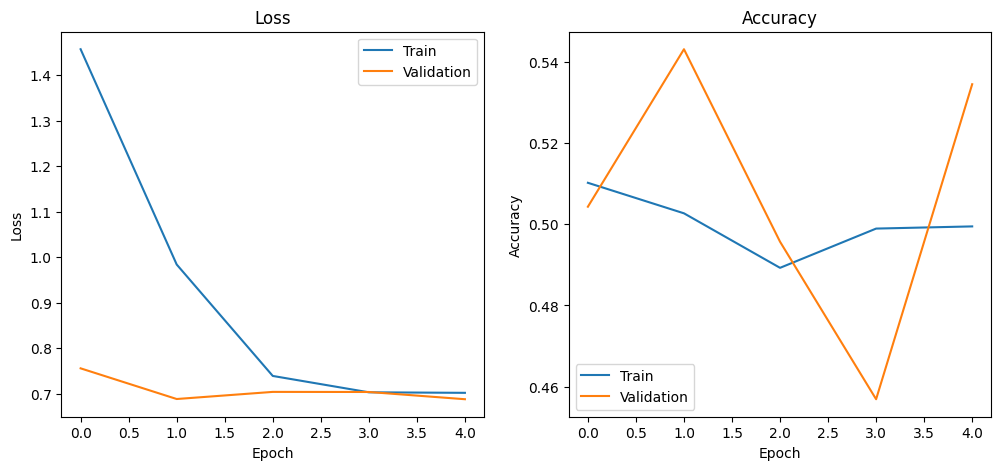

Maximum Train Accuracy:  0.5102040816326531


100%|██████████| 8/8 [00:00<00:00,  9.35it/s]

Test Error: 
 Accuracy: 50.9%, Avg loss: 0.695301 



In [66]:
# Train & test model
train_losses, val_losses, train_accuracies, val_accuracies = train(
    train_loader, val_loader, model, loss_fn, optimizer, 5)
print("Maximum Train Accuracy: ", max(train_accuracies))
test(test_loader, model, loss_fn)

### Results
Overall, roughly 3,000 samples of data were collected. These samples were collected in optimal conditions in locations and times with no periphery stimulus-producing distractions and no extraneous electrical signals. The first iteration of a classification model (EEG_Net_CNN) did not perform well enough over 100 epochs for use in a speller application. The model was initially trained on unnormalized data and did not achieve a usable accuracy. The model was then retrained on fully preprocessed data. It achieved a better yet still unusable testing accuracy of 51.30%. A more full analysis will be performed on the model after it has been optimized and has achieved a non-trivial performance gain over the baseline. A column chart comparing the baseline accuracy to the EEG_Net_CNN's accuracy is provided below:
<br><br>
![Barchart Comparison of EEG_Net_CNN Accuracy to the Baseline Accuracy](content/accuracy_chart.png)

### Next Steps
There is one main shortcoming in this project: the classification model's performance. This can be due to one or more of three factors:
- The quality and size of the training dataset.
- The quality of the data preprocessing.
- The architecture and training algorithm of the model.
##### Dataset
Great pains were taken to optimize the p300 response and to ensure that all data collected was of good quality. Furthermore, 3,000 samples of data would be enough to fully train a small classification network like the EEG_Net_CNN. However, if the size of the neural network is increased, then more samples will need to be collected.
##### Data Preprocessing
All the applied data preprocessing steps are generally needed for neural networks to converge quickly with signals data. Thus, none of the current preprocessing steps should be removed. However, the bandpass filter currently allows too much noise to filter through. The high frequency cutoff will be optimized further to reduce noise. Additionally, autoencoders are commonly used to extract features from signals data. An autoencoder will be trained and used to extract latent representations for further processing.
##### Model
The simple CNN was unable to parse the EEG data. Before trying different model architectures, we will tune the hyperparameters and model parameters, such as the convolution kernel sizes, to increase the accuracy of this model. CNNs have been successful in classifying EEG data for speller applications in the past. This means that an optimal size and optimal hyperparameters would likely enable our model to perform well. Recurrent neural networks (RNNs) have also been made to perform well on EEG data in the past. Because everybody's brain operates differently, each brain has a different baseline. Perhaps, a RNN can learn how to characterize a specific person's neural patterns in its hidden state. After optimizing the CNN, we will wrap the CNN with a LSTM RNN to test if a hidden state increases accuracy. Lastly, other neural networks have been trained on EEG data to detect the p300 stimulus response. Finding a pretrained model and modifying that model with additional layers for transfer learning could yield a usable model faster than building a network from scratch.